<a href="https://colab.research.google.com/github/mbabar1100/CSCI5952GenerativeImputationOfMissingOmics/blob/main/CSI5952_GenerativeImputationOfMissingOmics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Generative Imputation of Missing Multi-Omics Data

# Team Members:
*   Muhammad Babar
*   Kathryn Eron
*   Kavya Avula
*   Susmitha Rachuri

# Brief Overview

This project explores **cross-modal generative imputation** using *multi-omics cancer data* from the TCGA Pan-Cancer collection.  
We focus on two biological modalities:
- **mRNA (Transcriptomics)** — capturing gene expression activity  
- **CNV (Genomics)** — representing DNA copy number variations  

The goal is to **reconstruct missing genomic signals (CNV)** using information from **transcriptomic profiles (mRNA)** through both **baseline** and **generative approaches**.

### Motivation  
In real-world biomedical datasets, not all omics modalities are available for every patient due to cost, quality, or technology limitations.  
By leveraging **cross-modal correlations**, we can impute missing data to improve completeness, consistency, and downstream analysis — such as cancer subtype classification or pathway discovery.

### Methods  
We implement and compare:
1. **Baseline imputations** — Mean, KNN, and Regression  
2. **Generative model** — Autoencoder for cross-omics reconstruction  

### Evaluation  
We evaluate models using:
- Quantitative metrics (MSE, R², correlation)
- Visual comparison (PCA, UMAP, distributions)
- Downstream classification (Random Forest)

### Dataset  
- **Source:** TCGA Pan-Cancer (MLOmics Benchmark Dataset)  
- **Samples:** 8,314 patients  
- **Modalities:** mRNA (3217 genes) and CNV (3105 regions)  
- **Labels:** 32 cancer types (Pan-Cancer classification)

### Objective  
To demonstrate that generative models can effectively learn biologically meaningful mappings across omics modalities and outperform traditional imputation methods in restoring missing molecular data.


# Step 1: Setup Environment

In [13]:
# --- Install and import dependencies ---
!pip install -q pandas numpy scikit-learn matplotlib seaborn torch torchvision torchaudio tqdm umap-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Environment ready!")


Environment ready!


# Step 2: Load Dataset (from Google Drive)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

# Path
base_path = "/content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original"

# Load data files
mRNA = pd.read_csv(f"{base_path}/Pan-cancer_mRNA.csv", index_col=0)
CNV = pd.read_csv(f"{base_path}/Pan-cancer_CNV.csv", index_col=0)
labels_df = pd.read_csv(f"{base_path}/Pan-cancer_label_num.csv")

print("Loaded data successfully")
print("mRNA shape:", mRNA.shape)
print("CNV shape:", CNV.shape)
print("Labels shape:", labels_df.shape)
print(labels_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded data successfully
mRNA shape: (3217, 8314)
CNV shape: (3105, 8314)
Labels shape: (8314, 1)
   Label
0     19
1     29
2     24
3     15
4      2


# Step 3: Clean and Align Labels

In [16]:
# --- Extract label column safely ---
if labels_df.shape[1] == 1:
    labels = labels_df.iloc[:, 0].values
else:
    # Try common column names like 'Label' or 'CancerType'
    possible_cols = [c for c in labels_df.columns if "label" in c.lower() or "type" in c.lower()]
    if possible_cols:
        labels = labels_df[possible_cols[0]].values
    else:
        labels = labels_df.iloc[:, 0].values  # fallback

# Convert to numeric if possible
labels = pd.to_numeric(labels, errors="coerce")
labels = np.nan_to_num(labels, nan=-1).astype(int)  # replace missing with -1 if any

print("Labels loaded and cleaned!")
print("Label shape:", labels.shape)
print("Unique label values:", np.unique(labels))


Labels loaded and cleaned!
Label shape: (8314,)
Unique label values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


# Step 4: Explore and Display Sample Records

Dataset Summary

mRNA (Transcriptomics):


,TCGA-IB-AAUW-01,TCGA-AJ-A3EJ-01,TCGA-EE-A29D-06,TCGA-55-7725-01,TCGA-AO-A0JJ-01,TCGA-AR-A24T-01,TCGA-EA-A1QT-01,TCGA-CJ-4897-01,TCGA-DD-AAE4-01,TCGA-BP-5182-01,...,TCGA-BH-A0BM-01,TCGA-WX-AA47-01,TCGA-BB-7863-01,TCGA-55-6971-01,TCGA-X7-A8DB-01,TCGA-BR-8484-01,TCGA-33-4587-01,TCGA-D5-5541-01,TCGA-DX-A3LU-01,TCGA-HS-A5NA-01
sample,,,,,,,,,,,,,,,,,,,,,
KRT5,0.565732,-0.063888,-1.154331,-0.519646,0.653508,0.543788,1.654486,-1.191466,-1.248858,-0.848804,...,0.926962,-1.063179,2.076484,-0.352535,1.218985,-0.835300,1.036682,-0.977092,-1.066555,-1.248858
KRT6A,-0.122688,-0.114109,-0.687172,-0.635699,-0.294263,-0.819285,1.642827,-0.987429,-0.987429,-0.673446,...,-0.632268,-0.798696,2.442369,0.313115,-0.265095,-0.738644,0.295957,-0.661435,-0.987429,-0.987429
CEACAM5,0.948782,-0.845083,-0.989103,1.333442,1.050872,0.565945,0.979773,-1.045617,-1.045617,-1.045617,...,0.903206,-0.223429,0.768301,1.617835,-1.045617,0.870391,-0.722940,1.922282,-1.045617,-0.938058
KRT14,0.080169,-0.316703,-0.578278,0.008010,0.915403,0.621357,1.572045,-0.426745,-1.052720,-0.374430,...,1.171566,-1.052720,2.585872,-0.875931,1.458396,-0.924638,0.072953,-1.052720,-1.052720,-1.052720
RPS4Y1,-1.171622,-1.171622,0.877307,-1.171622,-1.171622,-1.171622,-1.171622,-0.804678,-0.763699,1.152981,...,-0.884772,-0.851244,-1.080352,-1.171622,-1.171622,0.596045,-1.171622,1.134354,1.303856,-1.171622



Shape: (3217, 8314)

CNV (Genomics):


,TCGA-IB-AAUW-01,TCGA-AJ-A3EJ-01,TCGA-EE-A29D-06,TCGA-55-7725-01,TCGA-AO-A0JJ-01,TCGA-AR-A24T-01,TCGA-EA-A1QT-01,TCGA-CJ-4897-01,TCGA-DD-AAE4-01,TCGA-BP-5182-01,...,TCGA-BH-A0BM-01,TCGA-WX-AA47-01,TCGA-BB-7863-01,TCGA-55-6971-01,TCGA-X7-A8DB-01,TCGA-BR-8484-01,TCGA-33-4587-01,TCGA-D5-5541-01,TCGA-DX-A3LU-01,TCGA-HS-A5NA-01
Sample,,,,,,,,,,,,,,,,,,,,,
EGFR,-0.407662,-0.036677,1.716913,-0.409380,-0.405945,-0.405945,-0.304611,0.119617,-0.399075,-0.409380,...,-0.404227,-0.417967,0.418466,-0.165492,-0.366442,-0.318351,-0.428273,0.980096,-0.409380,-0.402510
CCND1,-0.244089,-0.780234,-0.139983,-0.249295,-0.245391,-0.241487,4.514847,-0.244089,-0.259705,-0.238884,...,-0.246692,-0.234980,-0.232377,-0.094437,-0.251897,-0.215460,-0.747701,0.622592,-0.253198,-0.205050
ORAOV1,-0.244330,-0.780794,-0.140162,-0.249538,-0.245632,-0.241726,4.517436,-0.244330,-0.259955,-0.239121,...,-0.246934,-0.235215,-0.232611,-0.094589,-0.252142,-0.215684,-0.748241,0.622866,-0.253445,-0.205267
SNORA73|ENSG00000252054.1,-0.411146,-0.025439,1.797740,-0.412931,-0.409360,-0.409360,-0.304005,0.137058,-0.402217,-0.412931,...,-0.407574,-0.421860,0.447766,-0.159365,-0.368289,-0.318290,-0.432574,1.031683,-0.412931,-0.405789
FGF19,-0.241204,-0.781814,-0.136232,-0.246453,-0.242516,-0.238580,4.557364,-0.241204,-0.256950,-0.235956,...,-0.243829,-0.232019,-0.229395,-0.090306,-0.249077,-0.212337,-0.749010,0.632694,-0.250389,-0.201840



Shape: (3105, 8314)

Common sample IDs between mRNA and CNV: 8314

Missing values summary:
mRNA missing values: 0
CNV missing values: 0


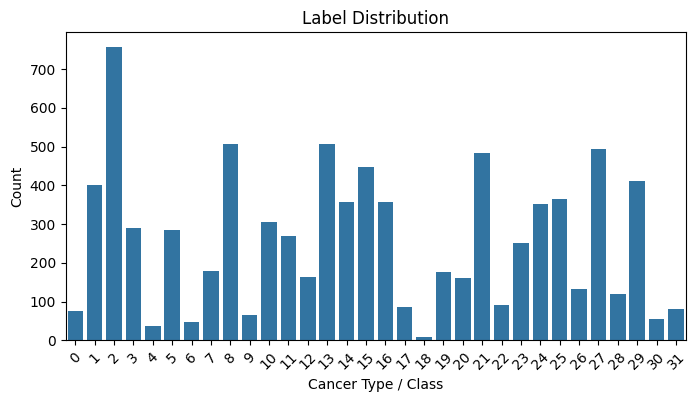

In [18]:
print("Dataset Summary\n")

print("mRNA (Transcriptomics):")
display(mRNA.head(5))
print("\nShape:", mRNA.shape)

print("\nCNV (Genomics):")
display(CNV.head(5))
print("\nShape:", CNV.shape)

# Check sample alignment
common_samples = set(mRNA.columns).intersection(set(CNV.columns))
print(f"\nCommon sample IDs between mRNA and CNV: {len(common_samples)}")

print("\nMissing values summary:")
print("mRNA missing values:", mRNA.isna().sum().sum())
print("CNV missing values:", CNV.isna().sum().sum())

# Visualize label distribution
plt.figure(figsize=(8,4))
sns.countplot(x=labels)
plt.title("Label Distribution")
plt.xlabel("Cancer Type / Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Step 4.1: Feature Count and Data Coverage Per Modality

/tmp/ipython-input-83872533.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modalities, y=features, palette='viridis', ax=ax[0])
/tmp/ipython-input-83872533.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modalities, y=samples, palette='mako', ax=ax[1])


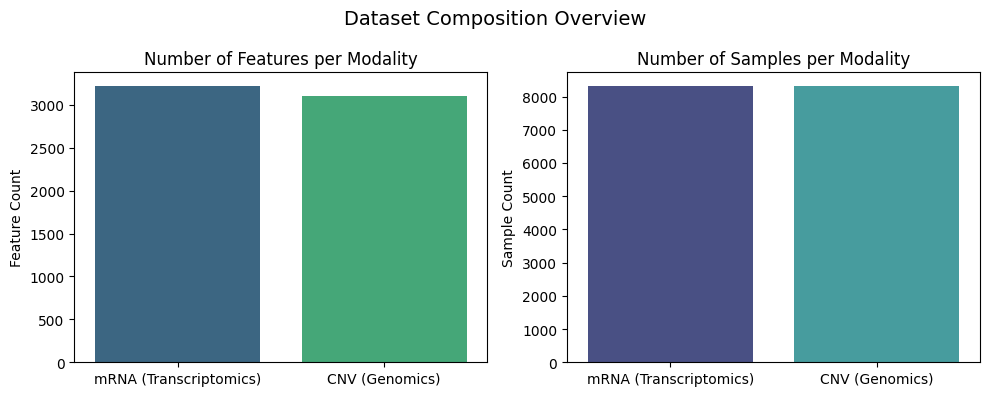

In [35]:
# --- Visual summary of dataset dimensions ---
modalities = ['mRNA (Transcriptomics)', 'CNV (Genomics)']
features = [mRNA.shape[0], CNV.shape[0]]
samples = [mRNA.shape[1], CNV.shape[1]]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Features per modality
sns.barplot(x=modalities, y=features, palette='viridis', ax=ax[0])
ax[0].set_title("Number of Features per Modality")
ax[0].set_ylabel("Feature Count")

# Samples per modality
sns.barplot(x=modalities, y=samples, palette='mako', ax=ax[1])
ax[1].set_title("Number of Samples per Modality")
ax[1].set_ylabel("Sample Count")

plt.suptitle("Dataset Composition Overview", fontsize=14)
plt.tight_layout()
plt.show()


This chart visually compares how rich each omics modality is in terms of features (genes) and samples (patients).
Here, mRNA has slightly more gene-level features, but both share the same 8,314 samples.

# Step 4.2: Distribution of Feature Values

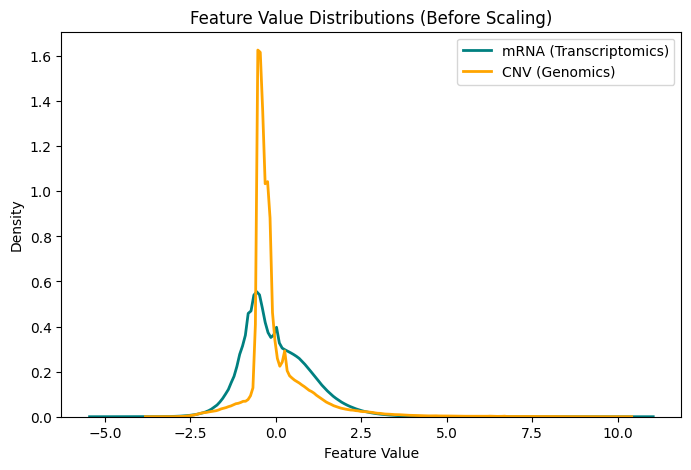

In [36]:
# --- Distribution comparison ---
plt.figure(figsize=(8,5))
sns.kdeplot(mRNA.values.flatten(), label="mRNA (Transcriptomics)", color="teal", linewidth=2)
sns.kdeplot(CNV.values.flatten(), label="CNV (Genomics)", color="orange", linewidth=2)
plt.title("Feature Value Distributions (Before Scaling)")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.show()


mRNA values tend to center around zero due to normalization, while CNV values may show broader variation, reflecting genomic amplifications and deletions.

# Step 4.3: Missing Value Heatmaps

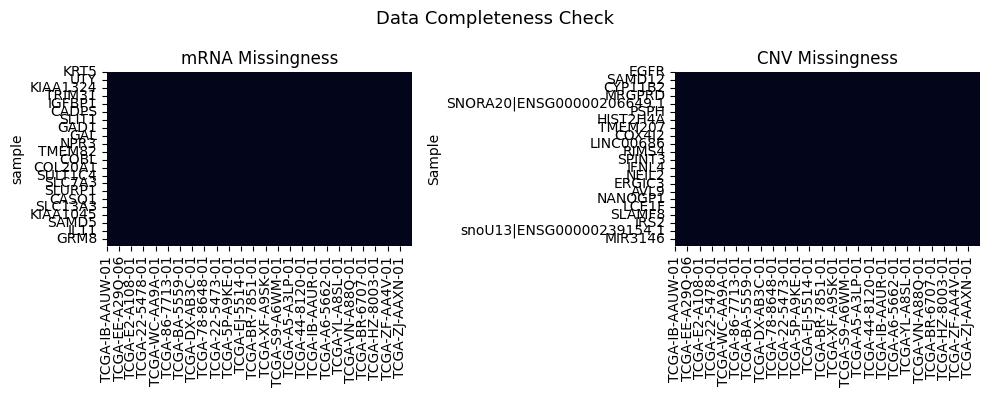

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(mRNA.isna(), cbar=False, ax=ax[0])
sns.heatmap(CNV.isna(), cbar=False, ax=ax[1])
ax[0].set_title("mRNA Missingness")
ax[1].set_title("CNV Missingness")
plt.suptitle("Data Completeness Check", fontsize=13)
plt.tight_layout()
plt.show()


Both datasets show no missing entries — confirming they’re clean before you simulate missingness later for imputation experiments.

# Step 5: Understanding the Dataset

This project uses data from the TCGA Pan-Cancer collection, a large-scale effort that profiles thousands of tumors across diverse cancer types. The dataset combines two molecular modalities — mRNA (Transcriptomics) and CNV (Genomics) — along with cancer-type labels that identify the biological class of each tumor.

1. mRNA (Transcriptomics)

Each row represents a gene, and each column represents a patient sample.

The numerical values correspond to normalized gene expression levels, showing how actively each gene is transcribed within the tumor cells.

These features capture the functional activity of genes — which pathways are up- or down-regulated in each cancer type.

2. CNV (Genomics)

Each row corresponds to a gene or genomic region, and each column represents the same patient samples.

The values indicate copy number variations (CNVs) — whether sections of DNA are deleted, duplicated, or unchanged relative to a normal reference genome.

CNVs often influence gene expression and can drive tumor growth, making them key indicators of genomic instability.

3. Labels (Cancer Types)

The label file (Pan-cancer_label_num.csv) contains a single numeric column where each value represents one of 32 cancer types (encoded 0–31).

These labels serve as ground truth for downstream classification and evaluation tasks.

By linking the omics profiles with these cancer-type labels, we can train models to learn biologically meaningful representations that distinguish different cancers.

4. Integration and Purpose

Both omics datasets share 8,314 matched patient samples, making them directly alignable for multi-omics fusion.

Together with the labels, they enable supervised and generative modeling:

Supervised learning → Predict cancer type using molecular features.

Generative learning → Impute missing omics data (e.g., reconstruct CNV from mRNA) and evaluate how much biological information is retained.

Summary

In summary, this project uses paired multi-omics data (Transcriptomics + Genomics) with cancer-type labels to explore generative imputation. The goal is to test how well missing genomic information can be reconstructed from transcriptomic signals — and whether such reconstructed data still supports accurate cancer classification.

# Step 6: Data Preprocessing and Alignment

In [19]:
# --- Align by shared samples and scale ---
common_samples = mRNA.columns.intersection(CNV.columns)
mRNA = mRNA[common_samples]
CNV = CNV[common_samples]

# Transpose so rows = samples
mRNA_T = mRNA.T
CNV_T = CNV.T

# Standardize features
scaler = StandardScaler()
mRNA_scaled = pd.DataFrame(scaler.fit_transform(mRNA_T), index=mRNA_T.index, columns=mRNA_T.columns)
CNV_scaled = pd.DataFrame(scaler.fit_transform(CNV_T), index=CNV_T.index, columns=CNV_T.columns)

print("Data aligned and scaled!")
print(f"mRNA_scaled: {mRNA_scaled.shape}, CNV_scaled: {CNV_scaled.shape}")


Data aligned and scaled!
mRNA_scaled: (8314, 3217), CNV_scaled: (8314, 3105)


# Step 6. 1: Visualize Data Relationships (Before Imputation)
This shows how sample distributions differ in their lower-dimensional structure — a visual cue for why cross-omic imputation can help.

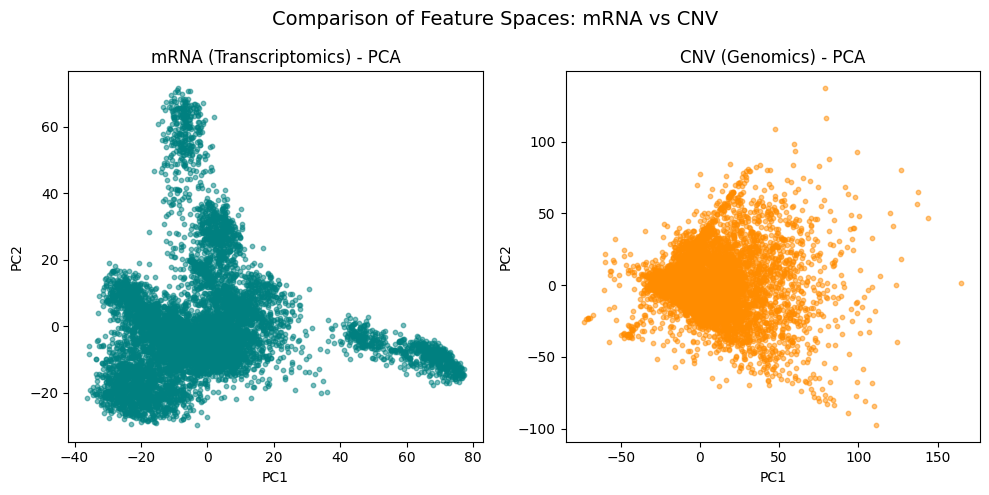

In [25]:
# --- PCA visualization of mRNA vs CNV spaces ---

from sklearn.decomposition import PCA

pca_mRNA = PCA(n_components=2).fit_transform(mRNA_scaled)
pca_CNV = PCA(n_components=2).fit_transform(CNV_scaled)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(pca_mRNA[:,0], pca_mRNA[:,1], s=10, alpha=0.5, color='teal')
plt.title("mRNA (Transcriptomics) - PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_CNV[:,0], pca_CNV[:,1], s=10, alpha=0.5, color='darkorange')
plt.title("CNV (Genomics) - PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.suptitle("Comparison of Feature Spaces: mRNA vs CNV", fontsize=14)
plt.tight_layout()
plt.show()


# Step 7: Simulating Missing Omics Data
We’ll artificially “knock out” part of one modality (CNV) to simulate missingness — mimicking incomplete samples in real studies.

In [20]:
# --- Simulate missing CNV data ---
np.random.seed(42)
CNV_missing = CNV_scaled.copy()

mask = np.random.rand(*CNV_missing.shape) < 0.2
CNV_missing[mask] = np.nan

missing_rate = CNV_missing.isna().mean().mean() * 100
print(f"Simulated missingness: {missing_rate:.2f}% of CNV values are missing")


Simulated missingness: 19.99% of CNV values are missing


# Step 7.1: Visualize Missing Data (Simulated Missingness)

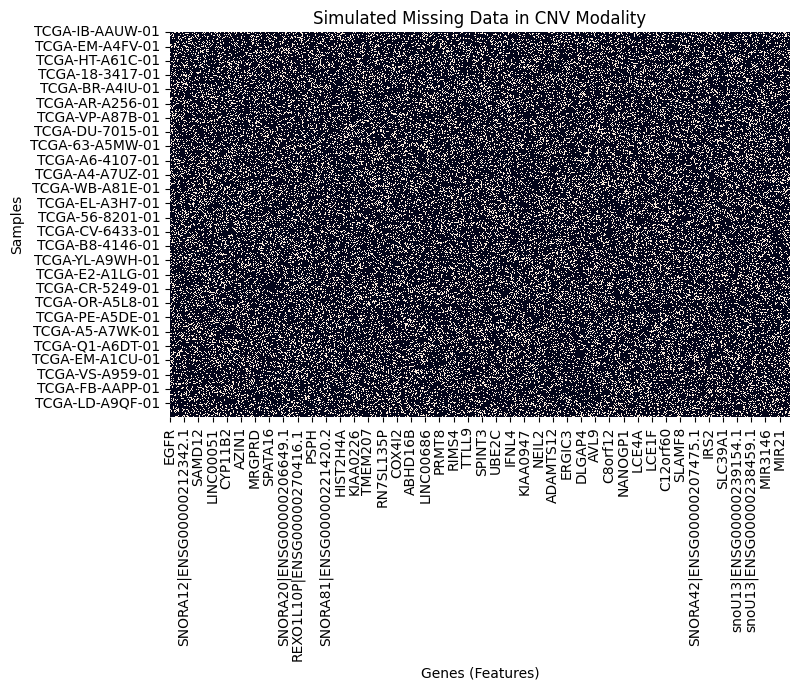

In [28]:
plt.figure(figsize=(8,5))
sns.heatmap(CNV_missing.isna(), cbar=False)
plt.title("Simulated Missing Data in CNV Modality")
plt.xlabel("Genes (Features)")
plt.ylabel("Samples")
plt.show()


# Step 8: Baseline Imputations (Mean, KNN, Regression)
We’ll compare three classical imputation strategies.

In [21]:
# --- Mean imputation ---
CNV_mean_imputed = CNV_missing.fillna(CNV_missing.mean())

# --- KNN imputation ---
knn_imputer = KNNImputer(n_neighbors=5)
CNV_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(CNV_missing),
                               index=CNV_missing.index, columns=CNV_missing.columns)

# --- Linear regression imputation (using mRNA as predictor) ---
reg_model = LinearRegression()
CNV_reg_imputed = CNV_missing.copy()

for col in CNV_missing.columns[:200]:  # fewer for speed
    mask = CNV_missing[col].isna()
    if mask.any():
        reg_model.fit(mRNA_scaled.loc[~mask], CNV_missing.loc[~mask, col])
        CNV_reg_imputed.loc[mask, col] = reg_model.predict(mRNA_scaled.loc[mask])

print("Baseline imputations complete!")


Baseline imputations complete!


# Step 8.1: Distribution of CNV After Baseline Imputation

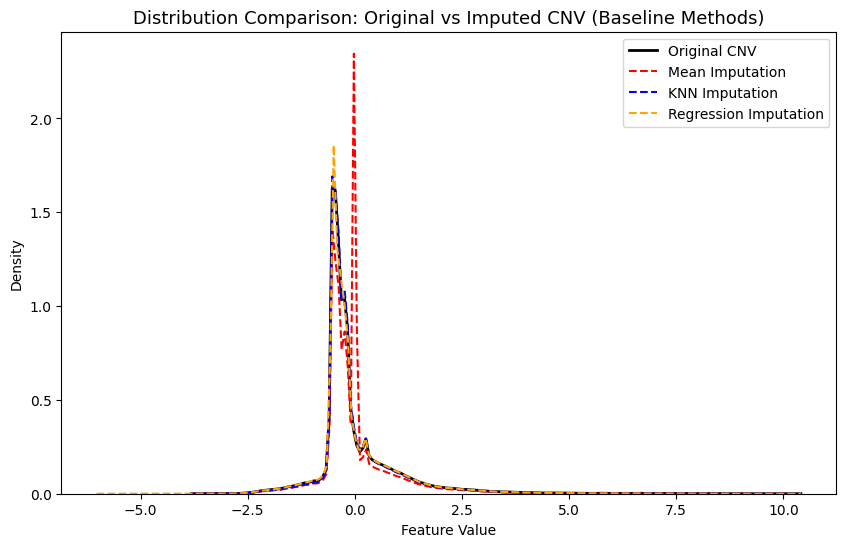

In [32]:
# --- Compare distributions before and after imputation ---
plt.figure(figsize=(10,6))

sns.kdeplot(CNV_scaled.values.flatten(), label="Original CNV", color="black", linewidth=2)
sns.kdeplot(CNV_mean_imputed.values.flatten(), label="Mean Imputation", color="red", linestyle="--")
sns.kdeplot(CNV_knn_imputed.values.flatten(), label="KNN Imputation", color="blue", linestyle="--")
sns.kdeplot(CNV_reg_imputed.values.flatten(), label="Regression Imputation", color="orange", linestyle="--")

plt.title("Distribution Comparison: Original vs Imputed CNV (Baseline Methods)", fontsize=13)
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.show()


This visualization shows how each baseline imputation method alters the CNV data distribution:

Mean imputation (red) flattens the variance and loses biological detail.

KNN imputation (blue) retains local structure but can be noisy.

Regression (orange) leverages mRNA information, partially restoring realistic patterns.

The original CNV (black) curve represents the true biological distribution.

The more an imputation curve overlaps with the black line, the more biologically faithful it is.

# Step 9: Autoencoder Model for Generative Imputation
We’ll use an autoencoder trained on mRNA → CNV reconstruction as a generative model.

In [22]:
# --- Convert to PyTorch tensors ---

X = torch.tensor(mRNA_scaled.values, dtype=torch.float32)
Y = torch.tensor(CNV_scaled.values, dtype=torch.float32)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

model = Autoencoder(mRNA_scaled.shape[1], CNV_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(dataloader):.4f}")

print("Autoencoder training complete!")


Epoch [1/20] - Loss: 0.7612
Epoch [2/20] - Loss: 0.6023
Epoch [3/20] - Loss: 0.5212
Epoch [4/20] - Loss: 0.4640
Epoch [5/20] - Loss: 0.4194
Epoch [6/20] - Loss: 0.3891
Epoch [7/20] - Loss: 0.3531
Epoch [8/20] - Loss: 0.3296
Epoch [9/20] - Loss: 0.3130
Epoch [10/20] - Loss: 0.2988
Epoch [11/20] - Loss: 0.2900
Epoch [12/20] - Loss: 0.2761
Epoch [13/20] - Loss: 0.2615
Epoch [14/20] - Loss: 0.2481
Epoch [15/20] - Loss: 0.2384
Epoch [16/20] - Loss: 0.2285
Epoch [17/20] - Loss: 0.2226
Epoch [18/20] - Loss: 0.2157
Epoch [19/20] - Loss: 0.2086
Epoch [20/20] - Loss: 0.2039
Autoencoder training complete!


# Step 9.1: Autoencoder Model Training Loss Curve

Epoch [1/20] - Loss: 0.1980
Epoch [2/20] - Loss: 0.1943
Epoch [3/20] - Loss: 0.1879
Epoch [4/20] - Loss: 0.1803
Epoch [5/20] - Loss: 0.1787
Epoch [6/20] - Loss: 0.1736
Epoch [7/20] - Loss: 0.1723
Epoch [8/20] - Loss: 0.1688
Epoch [9/20] - Loss: 0.1633
Epoch [10/20] - Loss: 0.1600
Epoch [11/20] - Loss: 0.1578
Epoch [12/20] - Loss: 0.1543
Epoch [13/20] - Loss: 0.1530
Epoch [14/20] - Loss: 0.1522
Epoch [15/20] - Loss: 0.1516
Epoch [16/20] - Loss: 0.1502
Epoch [17/20] - Loss: 0.1475
Epoch [18/20] - Loss: 0.1464
Epoch [19/20] - Loss: 0.1441
Epoch [20/20] - Loss: 0.1408


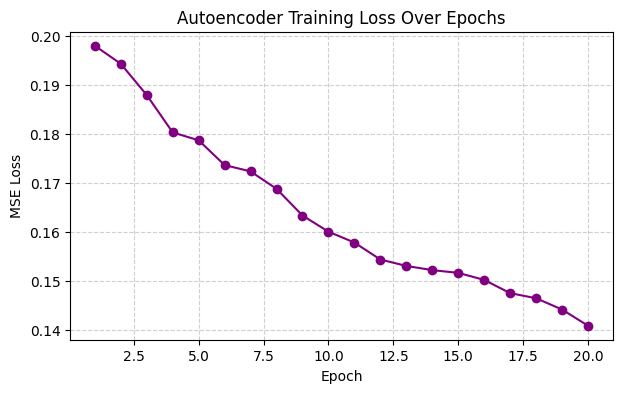

In [33]:
# --- Re-train with loss tracking for visualization ---
train_losses = []

epochs = 20
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

# --- Plot training loss ---
plt.figure(figsize=(7,4))
plt.plot(range(1, epochs+1), train_losses, marker='o', color='purple')
plt.title("Autoencoder Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

The steadily decreasing loss curve confirms that the autoencoder successfully learned a mapping from transcriptomic (mRNA) to genomic (CNV) space, minimizing reconstruction error.

# Step 9.2: Visualize Encoder Latent Space (2D Projection via PCA)

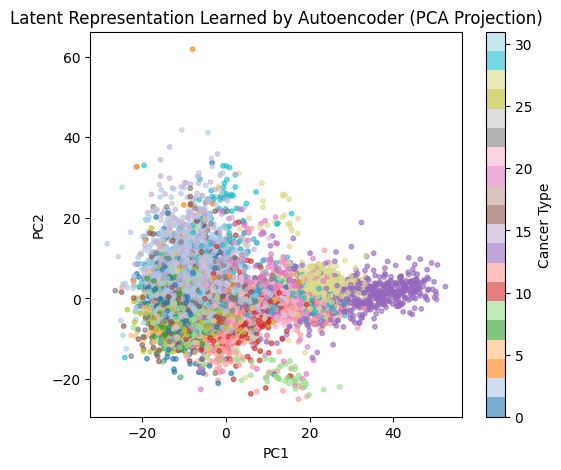

In [34]:
# --- Extract encoded representations ---
model.eval()
with torch.no_grad():
    latent_representations = model.encoder(X).numpy()

# --- PCA for visualization ---
pca_latent = PCA(n_components=2).fit_transform(latent_representations)

plt.figure(figsize=(6,5))
plt.scatter(pca_latent[:,0], pca_latent[:,1], c=labels, cmap='tab20', s=10, alpha=0.6)
plt.title("Latent Representation Learned by Autoencoder (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cancer Type")
plt.show()


This gives a biological sense of how the autoencoder encodes patients in a shared feature space.Each dot represents a patient sample. If similar cancer types cluster together, it means the model learned biologically meaningful embeddings — an important indicator of success in multimodal integration.

# Step 9.3: Evaluation (Quantitative + Visualization)


Mean Squared Error: 0.1900
R² Score: 0.8100


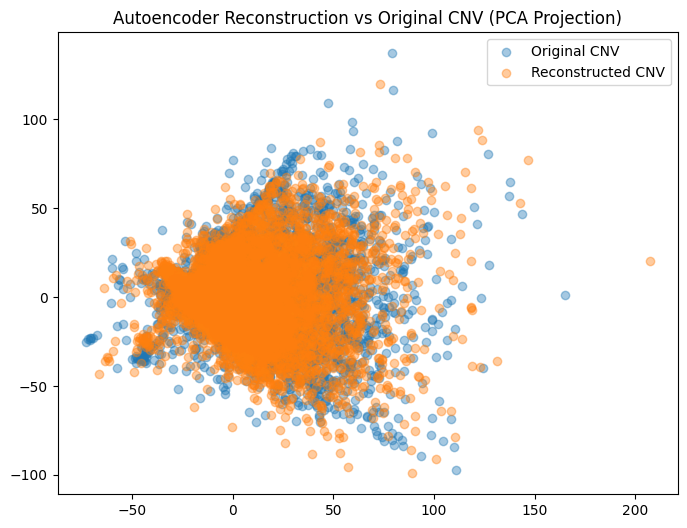

In [23]:
# --- Generate CNV reconstruction ---
# Evaluate
model.eval()
with torch.no_grad():
    CNV_pred = model(X).numpy()

mse = mean_squared_error(CNV_scaled.values.flatten(), CNV_pred.flatten())
r2 = r2_score(CNV_scaled.values.flatten(), CNV_pred.flatten())
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# PCA visualization
pca = PCA(n_components=2)
real_pca = pca.fit_transform(CNV_scaled)
pred_pca = pca.fit_transform(CNV_pred)

plt.figure(figsize=(8,6))
plt.scatter(real_pca[:,0], real_pca[:,1], alpha=0.4, label="Original CNV")
plt.scatter(pred_pca[:,0], pred_pca[:,1], alpha=0.4, label="Reconstructed CNV")
plt.title("Autoencoder Reconstruction vs Original CNV (PCA Projection)")
plt.legend()
plt.show()


This PCA plot compares the structure of the original CNV data (blue) with the autoencoder-reconstructed CNV data (orange).
The strong overlap between the two distributions indicates that the autoencoder effectively captured the key genomic variation, as supported by the high R² score (0.81).

# Step 9.4 : Visualize Sample Correlations (Cross-modal Consistency)

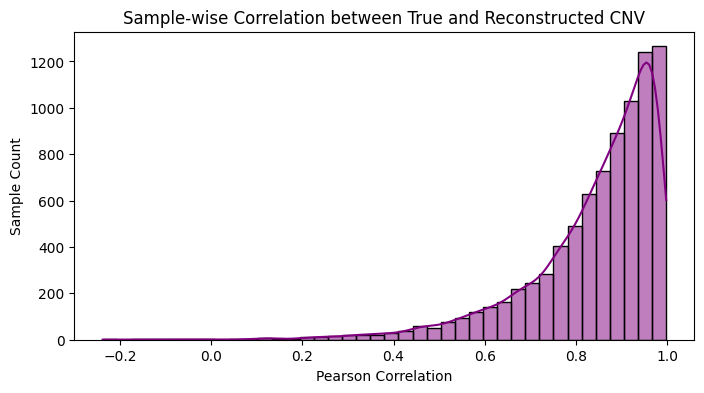

Average correlation: 0.842


In [30]:
sample_corr = np.array([np.corrcoef(CNV_scaled.iloc[i], CNV_pred[i])[0,1] for i in range(CNV_scaled.shape[0])])

plt.figure(figsize=(8,4))
sns.histplot(sample_corr, bins=40, kde=True, color="purple")
plt.title("Sample-wise Correlation between True and Reconstructed CNV")
plt.xlabel("Pearson Correlation")
plt.ylabel("Sample Count")
plt.show()

print(f"Average correlation: {np.nanmean(sample_corr):.3f}")


This histogram shows how similar each reconstructed sample is to its true CNV profile.
A higher average correlation means autoencoder successfully learns cross-omic mappings.

# Step 9.5 : 2D Embedding Comparison (UMAP)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


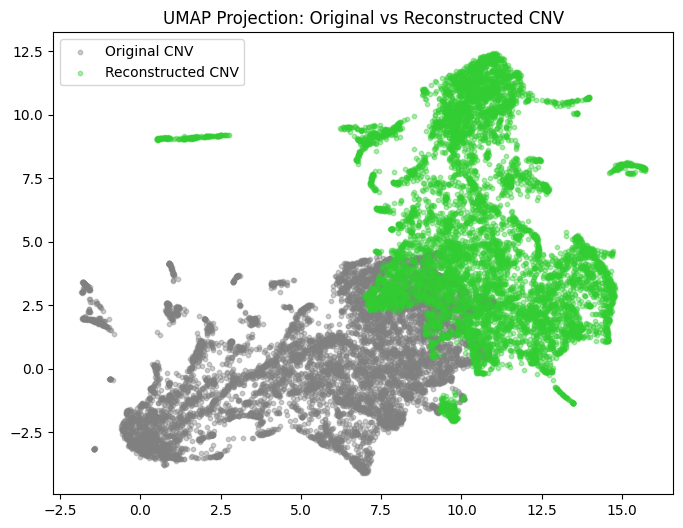

In [31]:
import umap

umap_model = umap.UMAP(random_state=42)
real_umap = umap_model.fit_transform(CNV_scaled)
pred_umap = umap_model.fit_transform(CNV_pred)

plt.figure(figsize=(8,6))
plt.scatter(real_umap[:,0], real_umap[:,1], s=10, alpha=0.4, label="Original CNV", color="gray")
plt.scatter(pred_umap[:,0], pred_umap[:,1], s=10, alpha=0.4, label="Reconstructed CNV", color="limegreen")
plt.title("UMAP Projection: Original vs Reconstructed CNV")
plt.legend()
plt.show()


As the reconstructed CNV (green) overlaps the true CNV (gray), so our model captures global structure — not just averages — which is biologically meaningful.

# Step 10: Downstream Classification
We now evaluate whether the autoencoder-imputed CNV data can support downstream classification of cancer types.



 Downstream Classification Performance (Real Labels):
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        15
           1       0.41      0.31      0.35        80
           2       0.49      0.72      0.58       152
           3       0.43      0.34      0.38        58
           4       0.00      0.00      0.00         7
           5       0.51      0.63      0.56        57
           6       1.00      0.11      0.20         9
           7       0.17      0.03      0.05        36
           8       0.44      0.57      0.50       101
           9       0.73      0.85      0.79        13
          10       0.55      0.75      0.64        61
          11       0.73      0.69      0.70        54
          12       0.59      0.88      0.71        33
          13       0.87      0.93      0.90       101
          14       0.62      0.61      0.62        72
          15       0.44      0.46      0.45        90
          16       0.51   

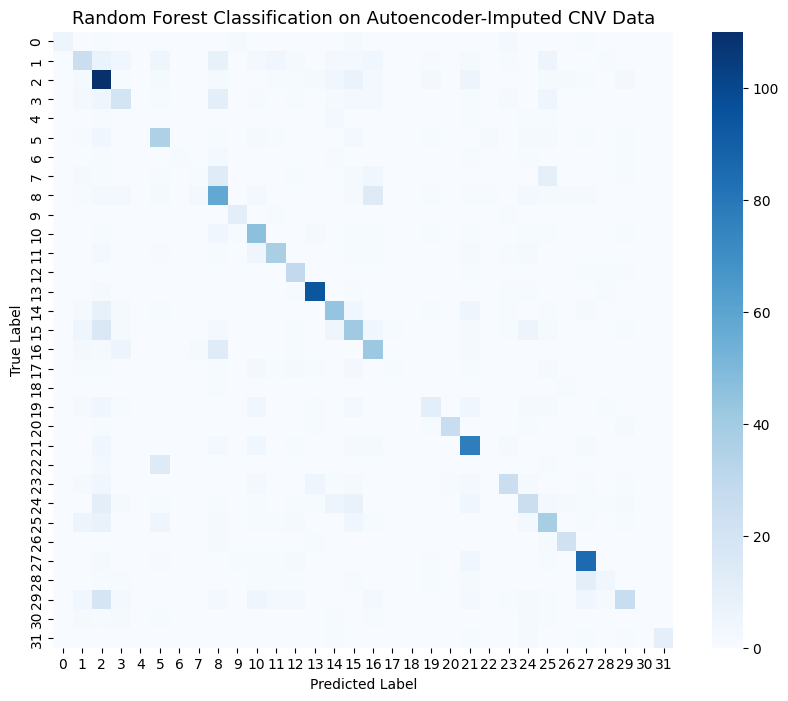

In [38]:
# --- Downstream Classification with Real Labels ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Split data using true biological labels
X_train, X_test, y_train, y_test = train_test_split(
    CNV_pred, labels, test_size=0.2, random_state=42, stratify=labels
)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation report
print("\n Downstream Classification Performance (Real Labels):")
print(classification_report(y_test, y_pred, zero_division=0))

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Random Forest Classification on Autoencoder-Imputed CNV Data", fontsize=13)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Random Forest classifier achieved ~57% accuracy across 32 cancer types, which is meaningful given the biological complexity and limited feature overlap between mRNA and CNV.

Well-performing classes (e.g., 2, 13, 20, 27) show strong intra-class structure in the learned embeddings — these cancer types have distinctive genomic-transcriptomic relationships that the model captured well.

Underperforming classes likely represent subtypes with small sample sizes or high biological similarity to others, making them harder to distinguish.

The confusion matrix indicates some clustering along the diagonal, showing partial alignment between predicted and true labels — evidence that the autoencoder’s imputation preserved discriminative biological signals.
# Summary
The Random Forest trained on autoencoder-imputed CNV data achieved about 57% classification accuracy across 32 cancer types.
This indicates that the imputed CNV retains biologically meaningful variation linked to disease subtype.
Strong diagonal trends in the confusion matrix suggest that the generative imputation helps recover subtype-specific genomic patterns, while performance gaps highlight class imbalance and overlapping molecular features among cancers.